In [1]:
# Use seaborn for pairplot
!pip install -q seaborn

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.0.0-beta1


In [3]:
%load_ext autoreload
%autoreload

import numpy as np
import pandas as pd
import pickle

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, GroupKFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score

from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import random

from equationmodel_ann import ann_mlp_regression, prediction_rmse_error, ann_linear_compare_graph, errorDist
from util import ADD_data_loader, combineDF, filteringDF, getFreeSpacePathLoss, makeXforGraphWithGroupingFrequency,\
                makeXforGraph, inverseScale, samplingData, normalizeData,train_2d_graph, train_3d_graph, groupWithFrequency

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

desired_width=620
pd.set_option('display.width', desired_width)
pd.set_option('display.max_columns',30)
pd.options.display.float_format = "{:.2f}".format

In [4]:
%autoreload

wt_fileList = {'../data/PLdata_paju_wt_400.csv':[('season', 0), ('frequency', 400), ('heightTB',100), ('heightB',7), ('heightM',2)],
            '../data/PLdata_paju_wt_1399.csv':[('season', 0), ('frequency', 1399), ('heightTB',100), ('heightB',7), ('heightM',2)],
            '../data/PLdata_paju_wt_2249.csv':[('season', 0), ('frequency', 2249), ('heightTB',100), ('heightB',7), ('heightM',2)]}
sp_fileList = {'../data/PLdata_paju_sp_400.csv':[('season', 0.5), ('frequency', 400), ('heightTB',100), ('heightB',7), ('heightM',2)],
            '../data/PLdata_paju_sp_1399.csv':[('season', 0.5), ('frequency', 1399), ('heightTB',100), ('heightB',7), ('heightM',2)],
            '../data/PLdata_paju_sp_2249.csv':[('season', 0.5), ('frequency', 2249), ('heightTB',100), ('heightB',7), ('heightM',2)]}
sm_fileList = {'../data/PLdata_paju_sm_400.csv':[('season', 1.0), ('frequency', 400), ('heightTB',100), ('heightB',7), ('heightM',2)],
            '../data/PLdata_paju_sm_1399.csv':[('season', 1.0), ('frequency', 1399), ('heightTB',100), ('heightB',7), ('heightM',2)],
            '../data/PLdata_paju_sm_2249.csv':[('season', 1.0), ('frequency', 2249), ('heightTB',100), ('heightB',7), ('heightM',2)]}

addWt = ADD_data_loader(wt_fileList)
print("winter data:",addWt.shape)
print("")
addSp = ADD_data_loader(sp_fileList)
print("spring data:",addSp.shape)
print("")
addSm = ADD_data_loader(sm_fileList)
print("summer data:",addSm.shape)
print("")

# print(addIksan.describe())
# print(addNonsan.describe())
# print(addPaju.describe())

addData = combineDF([addWt, addSp, addSm])
print("antenna_b height filtering-before(data count):",addData.shape)
addData = filteringDF(addData, 'heightTM', [10,100])
print("antenna_b height filtering-after(data count):",addData.shape)

print("freespace pathloss filtering-before(data count):",addData.shape)
addData['freePathloss'] = getFreeSpacePathLoss(addData['distance'],addData['frequency'])
addData = addData[addData['pathloss'] >= addData['freePathloss']]
print("freespace pathloss filtering-after(data count):",addData.shape)

# print("ADD data sample:\n",addData.head())

ADD data preprocessing
../data/PLdata_paju_wt_2249.csv: distance filtering(before):(110246, 4)
../data/PLdata_paju_wt_2249.csv: distance filtering(after):(22505, 4)
../data/PLdata_paju_wt_400.csv: distance filtering(before):(110440, 4)
../data/PLdata_paju_wt_400.csv: distance filtering(after):(22532, 4)
../data/PLdata_paju_wt_1399.csv: distance filtering(before):(110358, 4)
../data/PLdata_paju_wt_1399.csv: distance filtering(after):(22518, 4)
        type  distance  pathloss  heightTM  season  frequency  heightTB  heightB  heightM
type 93    m      1.00    107.14      0.02       0       2249       100        7        2
     94    m      1.01    105.75      0.02       0       2249       100        7        2
     95    m      1.01    103.32      0.02       0       2249       100        7        2
     96    m      1.01    103.28      0.02       0       2249       100        7        2
     97    m      1.01    103.61      0.02       0       2249       100        7        2
Combined data

data distribution(before)
       logDistance  logFrequency  logHeightTM  logExtendedHeightTratio    season  pathloss
count    123134.00     123134.00    123134.00                123134.00 123134.00 123134.00
mean          0.39          3.04         1.35                     0.64      0.54    127.74
std           0.16          0.31         0.19                     0.18      0.45     14.12
min           0.00          2.60         1.00                     0.02      0.00     85.47
25%           0.28          2.60         1.20                     0.51      0.00    117.05
50%           0.41          3.15         1.33                     0.66      0.50    128.39
75%           0.52          3.35         1.49                     0.78      1.00    138.74
max           0.60          3.35         2.00                     0.95      1.00    171.41
sampling shape(before):(123134, 6)
sampling shape(after):(6157, 6)
data distribution(after)
       logDistance  logFrequency  logHeightTM  logExtendedHeigh

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2881: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)


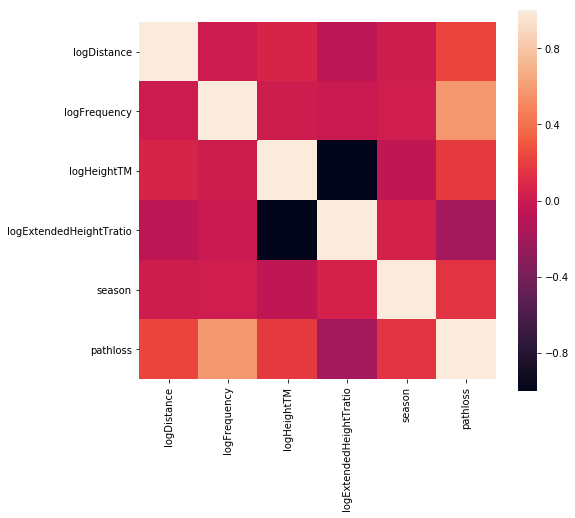

In [5]:
%autoreload

targetCols = ['logDistance', 'logFrequency', 'logHeightTM', 'logExtendedHeightTratio', 'season', 'pathloss']
xCols = ['logDistance', 'logFrequency', 'logHeightTM', 'logExtendedHeightTratio', 'season',]
yCols = 'pathloss'

samplingRatio = 0.05
addDataSampled = samplingData(addData[targetCols], samplingRatio, None)
# addDataSample.sort_values(by=['logDistance'])

sc = 'paju_5term'
scale = 'manual'

addDataNorm, normalizer = normalizeData(addDataSampled[targetCols], addDataSampled[yCols], scaler = scale)

print("\nADD data description")
print(addDataNorm.describe()['pathloss'])
print("\nCovariance Matrix - ADD data[Target Columns]")
print("Target Columns:", targetCols)
print(addDataNorm.cov()['pathloss'])

print("\nCorrelation Matrix - ADD data[Target Columns]")
print("Target Columns:", targetCols)
corrMat = addDataNorm.corr()
print(corrMat)
f, ax = plt.subplots(figsize=(8,7))
sns.heatmap(corrMat, square=True)

X = np.array(addDataNorm[xCols])
Xorigin = np.array(addData[xCols]) 
Y = np.array(addDataSampled[yCols])

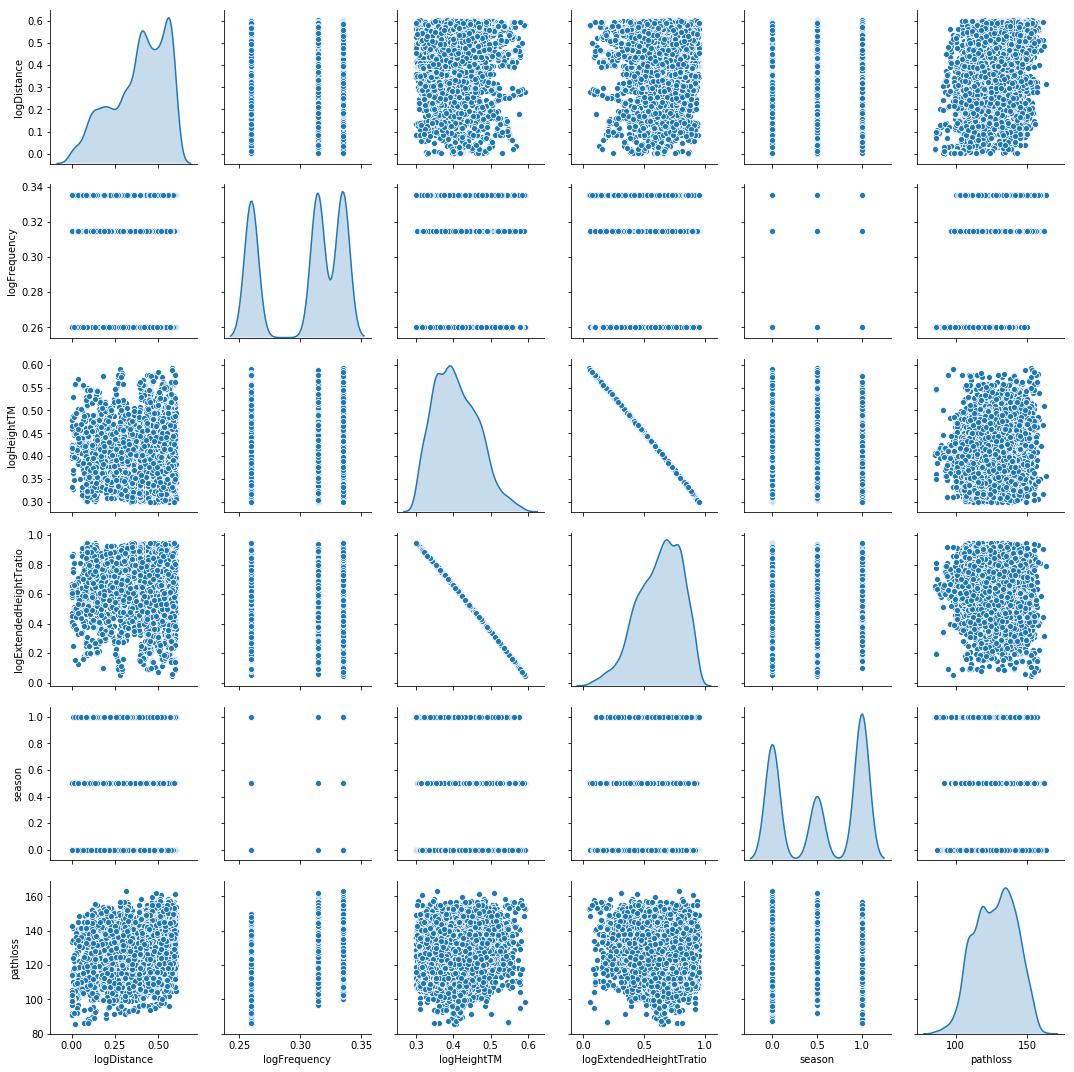

In [6]:
train_dataset = addDataNorm.sample(frac=0.8,random_state=0)
test_dataset = addDataNorm.drop(train_dataset.index)

sns.pairplot(train_dataset[targetCols], diag_kind="kde")
plt.show()

In [7]:
train_stats = train_dataset.describe()
train_stats.pop("pathloss")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
logDistance,4926.00,0.39,0.16,0.00,0.29,0.41,0.52,0.60
logFrequency,4926.00,0.30,0.03,0.26,0.26,0.31,0.34,0.34
logHeightTM,4926.00,0.41,0.06,0.30,0.36,0.40,0.45,0.59
logExtendedHeightTratio,4926.00,0.63,0.18,0.05,0.50,0.65,0.77,0.95
season,4926.00,0.55,0.45,0.00,0.00,0.50,1.00,1.00


In [8]:
train_labels = train_dataset.pop('pathloss')
test_labels = test_dataset.pop('pathloss')

In [9]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']
def denorm(x):
    return (x * train_stats['std']) + train_stats['mean']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [10]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mape',
                optimizer=optimizer,
                metrics=['mse', 'mae', 'mape'])
  return model

In [11]:
model = build_model()

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                384       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,609
Trainable params: 4,609
Non-trainable params: 0
_________________________________________________________________


In [13]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.28987235],
       [-0.25512192],
       [-0.27518645],
       [ 0.34325588],
       [-0.3358131 ],
       [-0.4335241 ],
       [ 0.08060687],
       [ 0.06250642],
       [-0.4017452 ],
       [-0.38870382]], dtype=float32)

In [14]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

EPOCHS = 1000

history = model.fit(
  train_dataset, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [15]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mape,mse,val_loss,val_mae,val_mape,val_mse,epoch
995,6.57,8.24,6.57,111.16,6.19,7.75,6.19,99.25,995
996,6.57,8.24,6.57,111.96,6.19,7.86,6.19,99.46,996
997,6.55,8.21,6.55,111.41,6.41,8.27,6.41,109.47,997
998,6.56,8.24,6.56,111.87,6.19,7.89,6.19,100.80,998
999,6.57,8.25,6.57,111.52,6.36,7.90,6.36,102.04,999


In [16]:
loss, mse, mae, mape = model.evaluate(test_dataset, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} dB".format(mae))
print("Testing set Root Mean Squared Error: {:5.2f} dB".format(mse**.5))
print("Testing set Mean Squared Error: {:5.2f} dB".format(mse))
print("Testing set Mean Absolute Percentage Error: {:5.2f} dB".format(mape))

Testing set Mean Abs Error:  8.11 dB
Testing set Root Mean Squared Error: 10.31 dB
Testing set Mean Squared Error: 106.25 dB
Testing set Mean Absolute Percentage Error:  6.56 dB


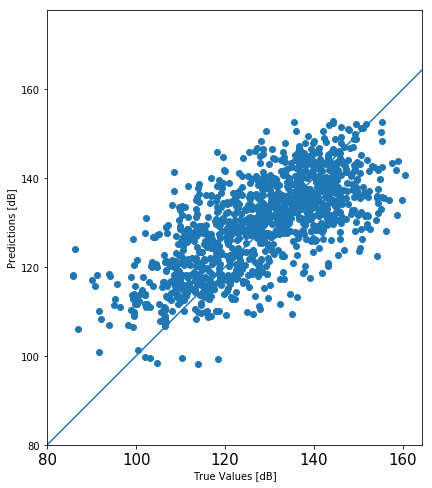

In [25]:
test_predictions = model.predict(test_dataset).flatten()

plt.figure(figsize=(15, 8))
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [dB]')
plt.ylabel('Predictions [dB]')
plt.axis('equal')
plt.axis('square')
plt.xlim([80,plt.xlim()[1]])
plt.ylim([80,plt.ylim()[1]])
_ = plt.plot([80, 180], [80, 180])

logDistance                 0.39
logFrequency                0.26
logHeightTM                 0.41
logExtendedHeightTratio     0.64
season                      0.53
pathloss                  116.40
dtype: float64
logDistance                 0.39
logFrequency                0.31
logHeightTM                 0.41
logExtendedHeightTratio     0.63
season                      0.56
pathloss                  131.29
dtype: float64
logDistance                 0.39
logFrequency                0.34
logHeightTM                 0.41
logExtendedHeightTratio     0.63
season                      0.55
pathloss                  135.29
dtype: float64


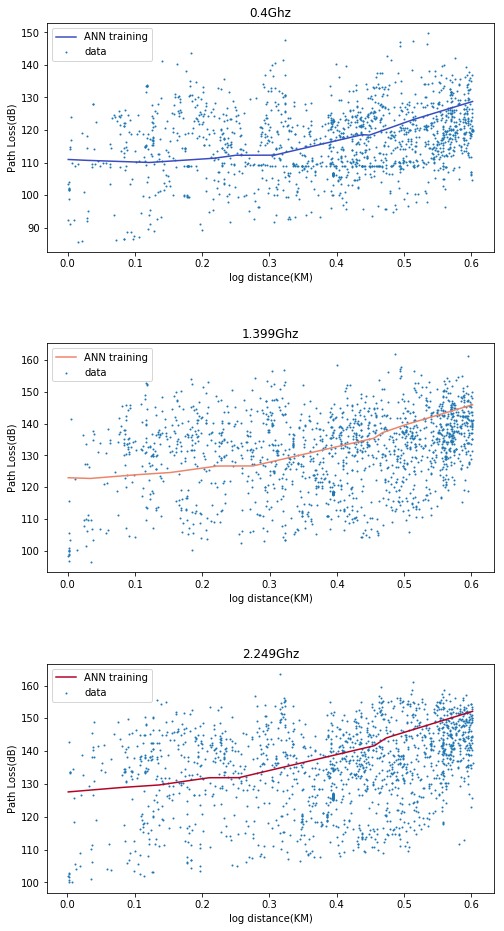

In [18]:
%autoreload
data = makeXforGraphWithGroupingFrequency(train_dataset,
                     pd.DataFrame(train_labels, columns=['pathloss']), ['logExtendedHeightTratio', 'logHeightTM', 'season'])

graphX = data[0]
graphY = data[1]
train_2d_graph(model, None, None,graphX, graphY, 'logDistance', "log distance(KM)")

3D graph for log distance and log frequency
logDistance                 0.39
logFrequency                0.30
logHeightTM                 0.41
logExtendedHeightTratio     0.63
season                      0.55
pathloss                  127.89
dtype: float64
Index(['logDistance', 'logFrequency', 'logHeightTM', 'logExtendedHeightTratio', 'season'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency  logHeightTM  logExtendedHeightTratio   season
count     10000.00      10000.00     10000.00                 10000.00 10000.00
mean          0.30          0.30         0.41                     0.63     0.55
std           0.18          0.02         0.00                     0.00     0.00
min           0.00          0.26         0.41                     0.63     0.55
25%           0.15          0.28         0.41                     0.63     0.55
50%           0.30          0.30         0.41                     0.63     0.55
75%           0.45          0.32         0

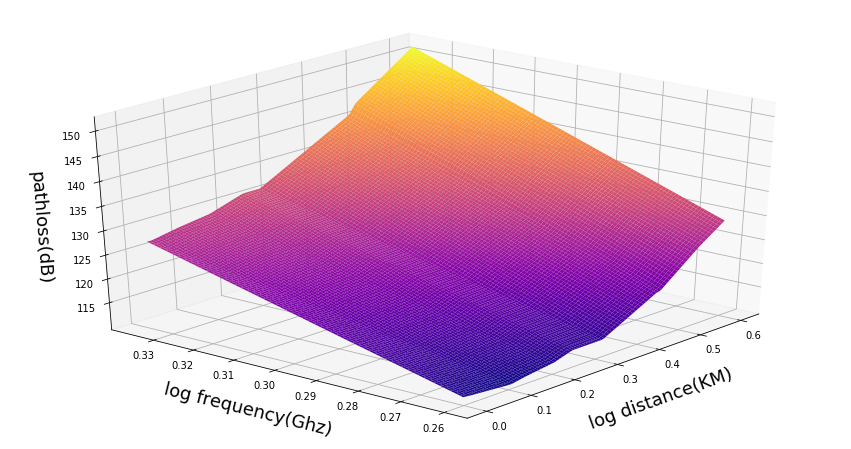

In [19]:
%autoreload
i = 1
print("3D graph for log distance and log frequency")
targetCols = ['logDistance', 'logFrequency']
xLabel,yLabel,zLabel = "log distance(KM)","log frequency(Ghz)","pathloss(dB)"
data = makeXforGraph(train_dataset,
                     pd.DataFrame(train_labels, columns=['pathloss']), targetCols)

graphX = data[0]
graphY = data[1]
train_3d_graph(model, graphX, graphY, targetCols, xLabel, yLabel, zLabel)

3D graph for log distance and log antenna height B+TB/M+TM ratio - trainset #1
logDistance                 0.39
logFrequency                0.30
logHeightTM                 0.41
logExtendedHeightTratio     0.63
season                      0.55
pathloss                  127.89
dtype: float64
Index(['logDistance', 'logFrequency', 'logHeightTM', 'logExtendedHeightTratio', 'season'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency  logHeightTM  logExtendedHeightTratio   season
count     10000.00      10000.00     10000.00                 10000.00 10000.00
mean          0.30          0.30         0.41                     0.50     0.55
std           0.18          0.00         0.00                     0.26     0.00
min           0.00          0.30         0.41                     0.05     0.55
25%           0.15          0.30         0.41                     0.27     0.55
50%           0.30          0.30         0.41                     0.50     0.55
75%    

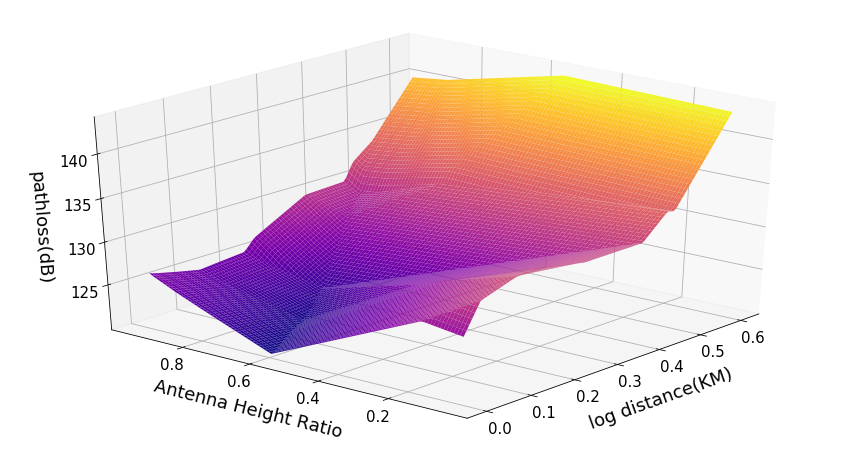

In [20]:
%autoreload
print("3D graph for log distance and log antenna height B+TB/M+TM ratio - trainset #{}".format(i))
xLabel,yLabel,zLabel = "log distance(KM)","Antenna Height Ratio","pathloss(dB)"
varX = ['logDistance', 'logExtendedHeightTratio']
data = makeXforGraph(train_dataset,
                     pd.DataFrame(train_labels, columns=['pathloss']), varX)

graphX = data[0]
graphY = data[1]
train_3d_graph(model, graphX, graphY, varX, xLabel, yLabel, zLabel)

In [21]:
%autoreload

#logDistance  logFrequency  logHeightB  logHeightM  logExtendedHeightTratio  logHeightTratio  logAntennaMulLogDistance
coefSum, interceptSum = np.array([0]*7), 0

ANNPred = model.predict(train_dataset)
ANNPred_test = model.predict(test_dataset)  
linearModel = Ridge(alpha=0.0001)
linearModel.fit(train_dataset, ANNPred)     
linearPredTrain = linearModel.predict(train_dataset)
linearPredTest = linearModel.predict(test_dataset)

In [22]:
print("\nObjective Function")
print("L_pathloss = {:6.2f}log_d + {:6.2f}log_f + {:6.2f}log_hm1 + {:6.2f}|log_(hb1/hm1)| + {:6.2f}s + {:6.2f}"\
  .format(linearModel.coef_[0],linearModel.coef_[1]
          *0.1,linearModel.coef_[2],\
          linearModel.coef_[3],linearModel.coef_[4],linearModel.intercept_)) 


Objective Function
L_pathloss =  20.85log_d +  26.69log_f + -585.59log_hm1 + -206.33|log_(hb1/hm1)| +   5.81s + 406.50


In [23]:
RMSE_ANN_TRAIN = np.sqrt(mean_squared_error(train_labels, ANNPred))
RMSE_ANN_TEST = np.sqrt(mean_squared_error(test_labels, ANNPred_test))
RMSE_LIN_TRAIN = np.sqrt(mean_squared_error(train_labels, linearPredTrain))
RMSE_LIN_TEST = np.sqrt(mean_squared_error(test_labels, linearPredTest))
RMSE_LIN_ANN = np.sqrt(mean_squared_error(ANNPred, linearPredTrain))

stat = np.array([RMSE_ANN_TRAIN, mean_absolute_error(train_labels, ANNPred),mean_absolute_percentage_error(train_labels, ANNPred),np.sqrt(mean_squared_log_error(train_labels, ANNPred)),r2_score(train_labels, ANNPred),\
                RMSE_ANN_TEST, mean_absolute_error(test_labels, ANNPred_test),mean_absolute_percentage_error(test_labels, ANNPred_test),np.sqrt(mean_squared_log_error(test_labels, ANNPred_test)),r2_score(test_labels, ANNPred_test),\
                RMSE_LIN_TRAIN, mean_absolute_error(train_labels, linearPredTrain),mean_absolute_percentage_error(train_labels, linearPredTrain),np.sqrt(mean_squared_log_error(train_labels, linearPredTrain)),r2_score(train_labels, linearPredTrain),\
                RMSE_LIN_TEST, mean_absolute_error(test_labels, linearPredTest),mean_absolute_percentage_error(test_labels, linearPredTest), np.sqrt(mean_squared_log_error(test_labels, linearPredTest)),r2_score(test_labels, linearPredTest),\
                RMSE_LIN_ANN, mean_absolute_error(ANNPred, linearPredTrain),mean_absolute_percentage_error(ANNPred, linearPredTrain), np.sqrt(mean_squared_log_error(ANNPred, linearPredTrain)),r2_score(ANNPred, linearPredTrain)])

print(pd.DataFrame(stat.reshape((5,5)),index=pd.Index(['ANN Train','ANN Test','Linear Train','Linear Test','Diff(ANN,Linear)']), columns=pd.Index(['RMSE','MAE','MAPE','RMSLE','R2'],name='TEST ERROR(dB)')))

TEST ERROR(dB)    RMSE  MAE  MAPE  RMSLE   R2
ANN Train        10.61 8.24 11.74   0.08 0.44
ANN Test         10.31 8.11 11.65   0.08 0.48
Linear Train     11.08 8.73  7.11   0.09 0.39
Linear Test      10.63 8.41  6.84   0.08 0.44
Diff(ANN,Linear)  3.85 3.03  9.23   0.03 0.87
